In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import keras
from keras.layers import Layer,InputLayer
import tensorflow as tf
from keras import layers, losses, optimizers,regularizers
from scipy.signal import freqz, welch
import sys,os
sys.path.append('/content')  # Add the folder containing your module to the Python path
os.environ['TF_ENABLE_ONEDNN_OPTS']= '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from Signal_proctools import *  # Now you can import your module

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
# Example usage:
processor = SignalProcessor(96000)
import tensorflow as tf
from tensorflow.keras.layers import Layer

class IIRFilterLayer(Layer):
    def __init__(self, b_initial, a_initial, clip_value=0.1, **kwargs):
        super(IIRFilterLayer, self).__init__(**kwargs)
        self.b_initial = b_initial  # initial b coefficients
        self.a_initial = a_initial  # initial a coefficients
        self.clip_value = clip_value  # Gradient clipping value to enhance stability

    def build(self, input_shape):
        self.b = self.add_weight(name='b',
                                 shape=(len(self.b_initial),),
                                 initializer=tf.constant_initializer(self.b_initial),
                                 trainable=True)
        self.a = self.add_weight(name='a',
                                 shape=(len(self.a_initial),),
                                 initializer=tf.constant_initializer(self.a_initial),
                                 trainable=True,
                                 constraint=lambda x: tf.clip_by_value(x, -self.clip_value, self.clip_value))  # Constrain a coefficients

    def get_config(self):
        config = super(IIRFilterLayer, self).get_config()
        config.update({
            'b_initial': self.b_initial,
            'a_initial': self.a_initial,
            'clip_value': self.clip_value
        })
        return config

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        buf_b = tf.zeros((batch_size, self.b.shape[0]), dtype=inputs.dtype)
        buf_a = tf.zeros((batch_size, self.a.shape[0] - 1), dtype=inputs.dtype)  # a[0] is not used in buffer

        outputs = tf.TensorArray(inputs.dtype, size=time_steps)

        inputs = tf.squeeze(inputs, axis=-1)

        for t in tf.range(time_steps):
            x = inputs[:, t]
            buf_b = tf.concat([x[:, tf.newaxis], buf_b[:, :-1]], axis=1)
            y = tf.reduce_sum(self.b * buf_b, axis=1) - tf.reduce_sum(self.a[1:] * buf_a, axis=1)
            buf_a = tf.concat([y[:, tf.newaxis], buf_a[:, :-1]], axis=1)
            outputs = outputs.write(t, y)

        outputs = outputs.stack()
        outputs = tf.transpose(outputs, [1, 0])
        outputs = tf.expand_dims(outputs, axis=-1)

        return outputs

class DistortionLayer(tf.keras.layers.Layer):
    def __init__(self, gain_initial_value=1.0, lower_bound=-1.0, upper_bound=1.0):
        super(DistortionLayer, self).__init__()
        self.gain = tf.Variable(initial_value=gain_initial_value, trainable=True, dtype=tf.float32)
        self.lower_bound = tf.Variable(initial_value=lower_bound, trainable=True, dtype=tf.float32)
        self.upper_bound = tf.Variable(initial_value=upper_bound, trainable=True, dtype=tf.float32)

    def call(self, inputs):
        # Apply gain and clip within the trainable bounds
        x = inputs * self.gain
        x = tf.clip_by_value(x, self.lower_bound, self.upper_bound)
        # Apply a non-linear transformation without changing the shape
        outputs = tf.sign(x) * (1 - tf.exp(-tf.abs(x)))
        # outputs = tf.expand_dims(x, axis=-1)
        return outputs  # Maintains the shape of the input tensor

    def get_config(self):
        config = super().get_config()
        config.update({
            "gain_initial_value": self.gain.numpy(),
            "lower_bound": self.lower_bound.numpy(),
            "upper_bound": self.upper_bound.numpy()
        })
        return config



2024-05-05 15:21:22.123072: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 15:21:22.168823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 15:21:22.168861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 15:21:22.168886: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 15:21:22.180735: I tensorflow/core/platform/cpu_feature_g

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100,
    decay_rate=0.99995)

# Adding ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Ensure this is a float
    patience=10,  # Ensure this is an integer
    verbose=1,
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001
)
Early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25,start_from_epoch=100)

filepath_="my_pedal_model.h5"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=filepath_,
    monitor="val_loss",  # Assuming you have a validation loss to monitor
    mode='min',          # Save the model when the monitored metric decreases
    save_best_only=True  # Save only the best model
)

optimizer_ = optimizers.legacy.Adam(learning_rate=lr_schedule) #https://keras.io/api/optimizers/

In [8]:
f=DistortionLayer(gain_initial_value=gain_init, lower_bound=low_init, upper_bound=high_init)
f.get_config()

{'name': 'distortion_layer_1',
 'trainable': True,
 'dtype': 'float32',
 'gain_initial_value': 1.0,
 'lower_bound': -0.5,
 'upper_bound': 0.5}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense,BatchNormalization,Activation,Dropout,LSTM
from tensorflow.keras.optimizers import Adam

# Read the WAV file
fs, x = wavfile.read("pedal_/whitenoise.wav", mmap=False)
fs, d = wavfile.read("pedal_/Setting3no_latency.wav", mmap=False)
# Example usage:
processor = SignalProcessor(fs)

length=100000
x = x.astype(float)[:length]
d = d.astype(float)[:length]
x /=32768.0
d /= 32768.0
x=x[:,0]
# d*=5

# Initialize coefficients
N=24
b_initial = np.zeros(N)  # example initial values for b
a_initial = np.zeros(N)  # example initial values for a
gain_init=1
low_init=-0.7
high_init=0.7

# Create the model
model = Sequential([
    InputLayer(input_shape=(None, 1)),
    DistortionLayer(gain_initial_value=gain_init, lower_bound=low_init, upper_bound=high_init),
    DistortionLayer(gain_initial_value=gain_init, lower_bound=low_init, upper_bound=high_init),
    IIRFilterLayer(b_initial=b_initial, a_initial=a_initial,clip_value=1.0),
    # LSTM(24),  # Adding an LSTM layer with 50 units
    # Dense(1000)
    ])

# Compile the model
model.compile(optimizer=optimizer_, loss='mse')

# 模型摘要
model.summary()

reference_signals = x.reshape(100,1000, 1)  # Reshape to (leng, 1, 1)
d = d[:length].reshape(100, 1000, 1)  # Reshape to (leng, 1, 1)

# Fit the model
# model.fit(x=reference_signals, y=d, epochs=100, batch_size=2)

load_model=0
if load_model==1:
  model = keras.models.load_model(filepath_)
    
model.fit(x=reference_signals,
          y=d,
          epochs=150,
          batch_size=10,
          callbacks=[Early_stopping],
          validation_split=0.1  # Assuming you want to validate using 20% of your data
          )  #訓練 AI


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distortion_layer_25 (Disto  (None, None, 1)           3         
 rtionLayer)                                                     
                                                                 
 distortion_layer_26 (Disto  (None, None, 1)           3         
 rtionLayer)                                                     
                                                                 
 iir_filter_layer_15 (IIRFi  (None, None, 1)           48        
 lterLayer)                                                      
                                                                 
Total params: 54 (216.00 Byte)
Trainable params: 54 (216.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/tmp/ipykernel_175523/4284613566.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = wavfile.read("pedal_/whitenoise.wav", mmap=False)
/tmp/ipykernel_175523/4284613566.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, d = wavfile.read("pedal_/Setting3no_latency.wav", mmap=False)


Epoch 1/150
9/9 [==============================] - 7s 666ms/step - loss: 0.0014 - val_loss: 5.6629e-04
Epoch 2/150
9/9 [==============================] - 5s 586ms/step - loss: 6.3765e-04 - val_loss: 4.7787e-04
Epoch 3/150
9/9 [==============================] - 5s 615ms/step - loss: 5.1351e-04 - val_loss: 4.1833e-04
Epoch 4/150
9/9 [==============================] - 6s 627ms/step - loss: 4.7993e-04 - val_loss: 3.9591e-04
Epoch 5/150
9/9 [==============================] - 5s 601ms/step - loss: 4.5887e-04 - val_loss: 3.8143e-04
Epoch 6/150
9/9 [==============================] - 5s 606ms/step - loss: 4.5217e-04 - val_loss: 3.7571e-04
Epoch 7/150
9/9 [==============================] - 5s 604ms/step - loss: 4.4867e-04 - val_loss: 3.7279e-04
Epoch 8/150
9/9 [==============================] - 5s 611ms/step - loss: 4.4702e-04 - val_loss: 3.7015e-04
Epoch 9/150
9/9 [==============================] - 6s 620ms/step - loss: 4.4522e-04 - val_loss: 3.6908e-04
Epoch 10/150
9/9 [=======================

In [55]:

# Assuming you have already trained the model
# Get the trained model's weights
trained_weights = model.get_weights()
print(trained_weights)

# Assuming the IIRFilterLayer is the second layer in the model
b_weights = trained_weights[6]  # Index 1 corresponds to the IIRFilterLayer's weights
a_weights = trained_weights[7]

print("b_initial:", b_weights)
print("a_initial:", a_weights)


[0.801774, -0.5, 0.5, 1.304758, -0.5, 0.5, array([ 0.03801277,  0.0299407 , -0.01370249, -0.00886163, -0.1972782 ,
       -0.34013116, -0.29025018, -0.21575025, -0.12694234, -0.1556688 ,
       -0.2097885 , -0.28319448, -0.2806591 , -0.25128958, -0.18853584,
       -0.14265355, -0.10865911, -0.07398006, -0.04279662, -0.00145726,
        0.01971372,  0.04190856,  0.03286393,  0.0339094 ], dtype=float32), array([ 0.0000000e+00, -3.1258547e-01, -2.6607314e-01, -8.2126930e-02,
        2.6385784e-01,  2.4750821e-01,  1.3063562e-01,  3.6439240e-02,
        9.5581345e-05,  1.2999296e-02,  1.7773101e-02,  3.7984032e-02,
        8.1683025e-03, -1.5160433e-02, -2.9794674e-02, -2.1478415e-02,
       -8.0542509e-03,  2.0857913e-02,  3.8520660e-02,  4.0196091e-02,
        2.1048870e-02, -1.9884700e-02, -1.8351013e-02,  6.0236532e-02],
      dtype=float32)]
b_initial: [ 0.03801277  0.0299407  -0.01370249 -0.00886163 -0.1972782  -0.34013116
 -0.29025018 -0.21575025 -0.12694234 -0.1556688  -0.2097885 

In [15]:
print("Shape of reference_signals:", reference_signals.shape)
print("Shape of targets (d):", d.shape)


Shape of reference_signals: (100, 1000, 1)
Shape of targets (d): (100, 1000, 1)


1/1 [==============================] - 0s 406ms/step
(1, 1000, 1)


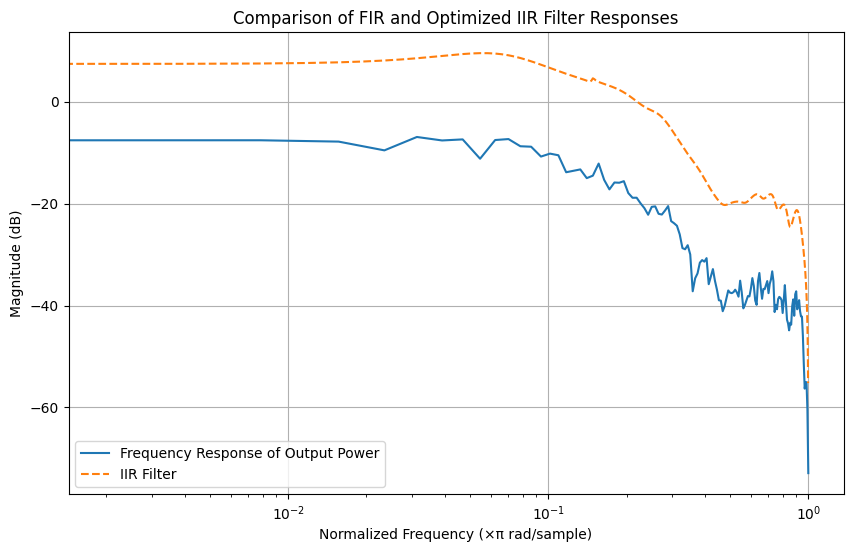

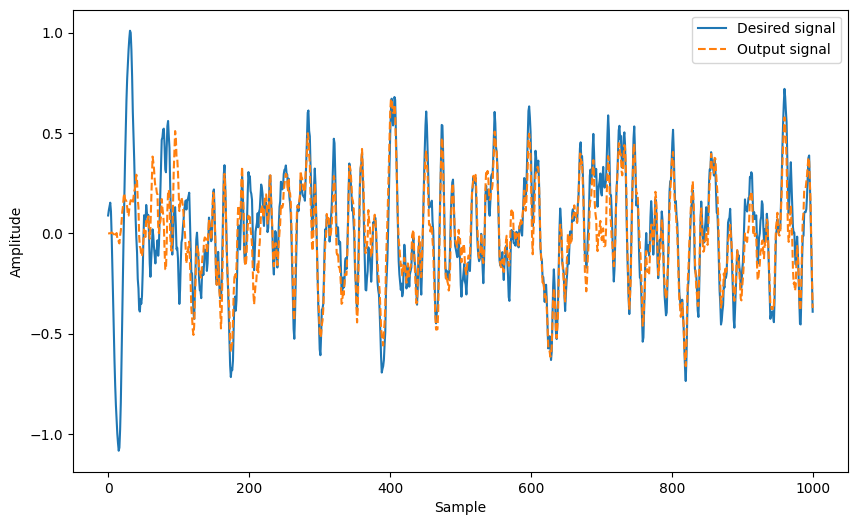

In [56]:
# 使用模型
length=1000
data = x[:length].reshape(1,length, 1)  # 随机数据作为输入
filtered_data = model.predict(data)
print(filtered_data.shape)  # 查看输出形状

filtered_data_ = filtered_data.reshape(-1)
desired_data=d[:len(filtered_data_)].reshape(-1)

# mse=processor.custom_mse(desired_data, filtered_data)
# print("mse:",mse)
# Compute the power spectral density using Welch's method
frequencies, power = welch(filtered_data_, fs=2*np.pi, nperseg=256)  # `fs=2*np.pi` normalizes frequency to [0, 1]

# Normalize frequencies to [0, 1] range where 1 corresponds to the Nyquist frequency
normalized_frequencies = frequencies / np.pi

# Convert power to decibels (dB)
power_db = 10 * np.log10(power)

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(normalized_frequencies, power_db, label='Frequency Response of Output Power')
plt.title('Power Spectral Density in dB')
plt.xlabel('Normalized Frequency (x pi rad/sample)')
plt.ylabel('Power (dB)')
# plt.show()
# Frequency response of the optimized IIR filter
a=a_weights
a[0]=1
freq, response_iir_opt = freqz(b_weights, a_weights)

# Plotting the responses
plt.semilogx(freq / np.pi, 20 * np.log10(abs(response_iir_opt)), label='IIR Filter', linestyle='--')
plt.title('Comparison of FIR and Optimized IIR Filter Responses')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()


# Plot the x and y signals

plt.figure(figsize=(10, 6))
plt.plot(desired_data[:length], label="Desired signal")
plt.plot(filtered_data_[:length],'--', label="Output signal")

# Add labels and title
plt.xlabel("Sample")
plt.ylabel("Amplitude")


# Add legend
plt.legend()

# Show the plot
plt.show()

1/1 [==============================] - 1s 817ms/step
(1, 10000, 1)


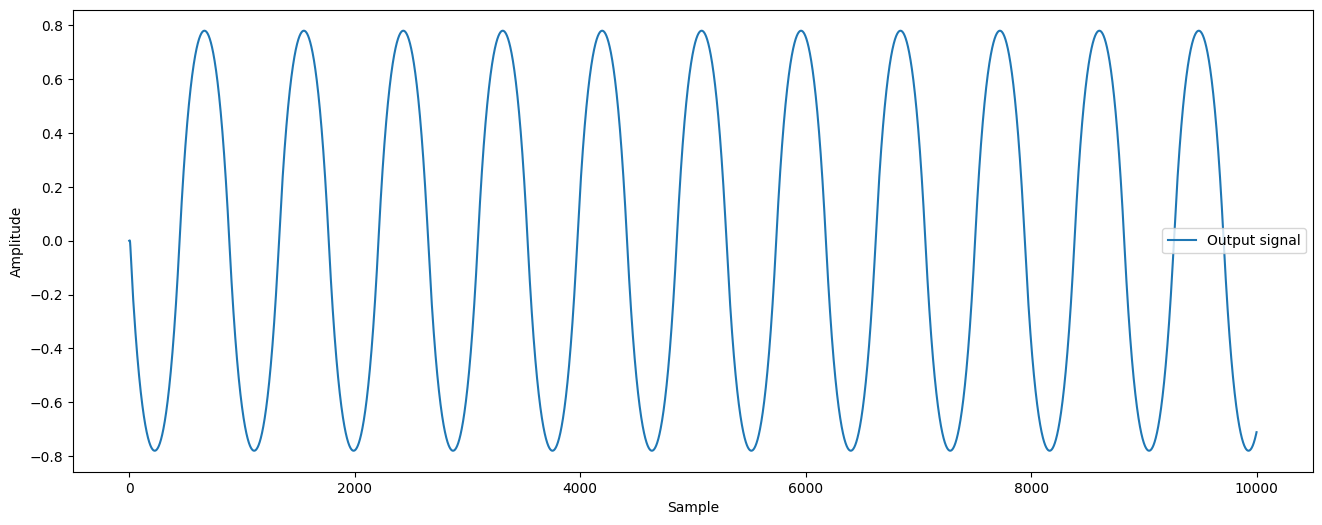

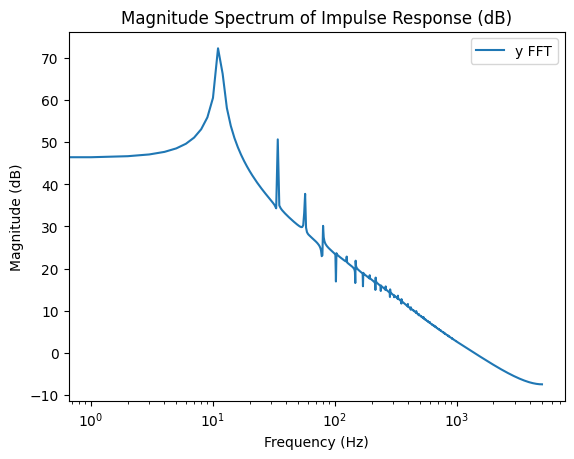

In [59]:
length=10000
t = np.arange(length) / fs
x_ = 0.6*np.sin(2 * np.pi * 50 * t)
data = x_[:length].reshape(1,length, 1)  # 随机数据作为输入
filtered_data = model.predict(data)
print(filtered_data.shape)  # 查看输出形状

plt.figure(figsize=(16, 6))
plt.cla()
plt.plot(filtered_data_[:length], label="Output signal")

# Add labels and title
plt.xlabel("Sample")
plt.ylabel("Amplitude")

# Add legend
plt.legend()
# Show the plot
plt.show()

filtered_data_ = filtered_data.reshape(-1)
magnitude_spectrum = np.abs(np.fft.fft(filtered_data_))

# Convert the magnitude spectrum to dB
db_spectrum = 20 * np.log10(magnitude_spectrum )
db_spectrum_Y=db_spectrum[:int(len(db_spectrum)/2)]
# Plot the magnitude spectrum in dB using a logarithmic scale
plt.semilogx(db_spectrum_Y,label="y FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Magnitude Spectrum of Impulse Response (dB)")
# Add legend
plt.legend()
plt.show()

In [ ]:

y=[]
bufb,bufa = np.zeros(len(a_coeffs)),np.zeros(len(a_coeffs)-1)
for n in range(len(x)):
  out, bufb,bufa = processor.iir_convolution(x[n], a_weights, b_weights ,bufa, bufb)
  y.append(out)

# Plot the x and y signals
plt.plot(t,y, label="Our AI filter")

# Add labels and title
plt.xlabel("time (s)")
plt.ylabel("Amplitude")

# Add legend
plt.legend()

# Show the plot
plt.show()